In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# get train & test csv files as a DataFrame
limit_rows   = 7000000

train_df = pd.read_csv("train_encoded.csv", nrows=limit_rows)

unique_ids   = pd.Series(train_df["ncodpers"].unique())
limit_people = 1.2e4
unique_id    = unique_ids.sample(n=limit_people)
train_df     = train_df[train_df.ncodpers.isin(unique_id)]

In [3]:
train_df.head()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,fecha_dato_month,fecha_dato_year,month_int,fecha_alta_month,fecha_alta_year,fecha_alta_day,fecha_alta_month_int
108,1050499,0,0,1,23,0,35,1,1,1,...,0,0,0,1,0,1,8,-3,10,8
118,1050560,0,0,1,23,0,35,1,1,0,...,0,0,0,1,0,1,8,-3,10,8
148,1050548,0,0,0,27,0,35,1,1,0,...,0,0,1,1,0,1,8,-3,10,8
154,1050874,0,0,1,27,0,35,1,1,0,...,0,0,0,1,0,1,8,-3,10,8
222,1050919,0,0,1,24,0,35,1,1,1,...,0,0,0,1,0,1,8,-3,10,8


In [4]:
train_df.columns

Index([u'ncodpers', u'ind_empleado', u'pais_residencia', u'sexo', u'age',
       u'ind_nuevo', u'antiguedad', u'indrel', u'indrel_1mes', u'tiprel_1mes',
       u'indresi', u'indext', u'conyuemp', u'canal_entrada', u'indfall',
       u'tipodom', u'cod_prov', u'ind_actividad_cliente', u'renta',
       u'segmento', u'ind_ahor_fin_ult1', u'ind_aval_fin_ult1',
       u'ind_cco_fin_ult1', u'ind_cder_fin_ult1', u'ind_cno_fin_ult1',
       u'ind_ctju_fin_ult1', u'ind_ctma_fin_ult1', u'ind_ctop_fin_ult1',
       u'ind_ctpp_fin_ult1', u'ind_deco_fin_ult1', u'ind_deme_fin_ult1',
       u'ind_dela_fin_ult1', u'ind_ecue_fin_ult1', u'ind_fond_fin_ult1',
       u'ind_hip_fin_ult1', u'ind_plan_fin_ult1', u'ind_pres_fin_ult1',
       u'ind_reca_fin_ult1', u'ind_tjcr_fin_ult1', u'ind_valo_fin_ult1',
       u'ind_viv_fin_ult1', u'ind_nomina_ult1', u'ind_nom_pens_ult1',
       u'ind_recibo_ult1', u'fecha_dato_month', u'fecha_dato_year',
       u'month_int', u'fecha_alta_month', u'fecha_alta_year',
       

## Data Cleaning

### ind_actividad_cliente
Activity index (1, active customer; 0, inactive customer)  
should be conducted at the very fist step

In [5]:
train_df.ind_actividad_cliente.value_counts()

 0    47107
 1    45466
-1      334
Name: ind_actividad_cliente, dtype: int64

In [6]:
train_df.ind_actividad_cliente.isin([-1]).sum()

334

these entities should be excluded from the model.

In [7]:
train_df = train_df[train_df.ind_actividad_cliente != -1]

### ind_nuevo
 which indicates whether a customer is new or not

In [8]:
train_df["ind_nuevo"].unique()

array([0, 1], dtype=int64)

In [9]:
train_df["ind_nuevo"].isin([-1]).sum()

0

Let's see if we can fill in missing values by looking how many months of history these customers have.

In [10]:
months_active = train_df.loc[train_df["ind_nuevo"].isin([-1]),:].groupby("ncodpers", sort=False).size()
months_active.max()

nan

Looks like these are all new customers, so replace accordingly.

In [11]:
train_df.ix[train_df["ind_nuevo"].isin([-1]),"ind_nuevo"] = 1

### antiguedad
Customer seniority (in months)

In [12]:
train_df["antiguedad"].unique()

array([ 35,  34,  36,  38,  12,  39,  26,  37,  20,  24,  32,  31,  28,
        29,   6,  27,  30,  21,  33,  47,  19,  46,  22,  45,  10,  57,
        58,  56,  59,  54,  53,  55,  62,  61,  63,  14,  60,  16,   8,
        48,  50,  51,  52,  49,  43,  44,  41,  40,  42,  18,  11,   9,
        13,  15,   7,   4,  23,  25,  17,   2, 165,  93, 164, 160, 166,
       167, 162, 158, 168, 147, 135, 107, 118, 157, 184, 130, 163, 126,
       154, 153,  99, 133, 143, 119, 139, 201,  95, 161, 155, 150, 172,
       170,  72, 124, 141, 171,  70,  89, 159, 174, 156, 173, 169, 145,
       112,  80,  92, 137, 179, 151, 148, 102, 152, 134, 131, 101, 138,
       117, 109,  82, 149,  87,  97, 114, 103,  73, 121, 113,  85, 123,
       111, 136, 128, 209, 193, 210, 202, 191, 178, 228, 211, 208, 206,
       207, 196, 146, 200, 186, 213, 212,  84,  81, 215, 216, 214, 198,
       183, 189, 190, 199, 195, 204, 205, 203, 194, 232, 235, 234,  77,
       230, 226, 229, 231, 108, 129, 187, 241, 240, 239, 238, 24

In [13]:
train_df["antiguedad"].isin([-1]).sum()

0

same as ind_nuevo. Let's see if those are same customers.

In [14]:
train_df.ix[train_df["antiguedad"].isin([-1]),"ind_nuevo"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: ind_nuevo, dtype: float64

same customers. Let's give them minimum seniority.

In [15]:
train_df.ix[train_df["antiguedad"].isin([-1]),"antiguedad"] = train_df["antiguedad"].min()

### fetcha_alta
Same entries don't have the date they joined the company.
- missing values are converted as below when data are squeezed  
DF['fecha_alta'] = DF['fecha_alta'].map(lambda x: '2020-00-00' if x == -1 else x)  
DF['fecha_alta_month'] = DF['fecha_alta'].map(lambda x: int(x[5:7])).astype(np.int8)  
DF['fecha_alta_year'] = DF['fecha_alta'].map(lambda x: int(x[0:4]) - 2015).astype(np.int8)  
DF['fecha_alta_day'] = DF['fecha_alta'].map(lambda x: int(x[8:10])).astype(np.int8)  
DF['fecha_alta_motnh_int'] = (DF['fecha_alta_month'] + 12 * DF['fecha_dato_year']).astype(np.int8)


In [16]:
train_df["fecha_alta_month"].isin([00]).sum()

0

filling missing values with medians respectively.

In [17]:
# fecha_alta_month
monthes = train_df.ix[:,"fecha_alta_month"].sort_values().reset_index()
median_month = int(np.median(monthes))
train_df.ix[train_df.fecha_alta_month.isin([-1]), "fecha_alta_month"] = monthes.ix[median_month, "fecha_alta_month"]
# fecha_alta_day
days = train_df.ix[:,"fecha_alta_day"].sort_values().reset_index()
median_day = int(np.median(days))
train_df.ix[train_df.fecha_alta_day.isin([-1]), "fecha_alta_day"] = days.ix[median_day, "fecha_alta_day"]
# fecha_alta_year
years = train_df.ix[:,"fecha_alta_year"].sort_values().reset_index()
median_year = int(np.median(years))
train_df.ix[train_df.fecha_alta_year.isin([-1]), "fecha_alta_year"] = years.ix[median_year, "fecha_alta_year"]
# fecha_alta_month_int
month_int = train_df.ix[:,"fecha_alta_month_int"].sort_values().reset_index()
median_month_int = int(np.median(month_int))
train_df.ix[train_df.fecha_alta_month_int.isin([-1]), "fecha_alta_month_int"] = month_int.ix[median_month_int, "fecha_alta_month_int"]

### indrel
1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)

In [18]:
train_df["indrel"].unique()

array([1, 2], dtype=int64)

In [19]:
train_df["indrel"].isin([-1]).sum()

0

In [20]:
train_df["indrel"].value_counts()

1    92442
2      131
Name: indrel, dtype: int64

filling with the most frequent values

In [21]:
train_df.ix[train_df.indrel.isin([-1]),"indrel"] = 1

### tipodom
Addres type. 1, primary address

In [22]:
train_df["tipodom"].value_counts()

1    92573
Name: tipodom, dtype: int64

doens't seem to be meaningful. so drop it.

In [23]:
train_df.drop(["tipodom"],axis=1,inplace=True)

### age

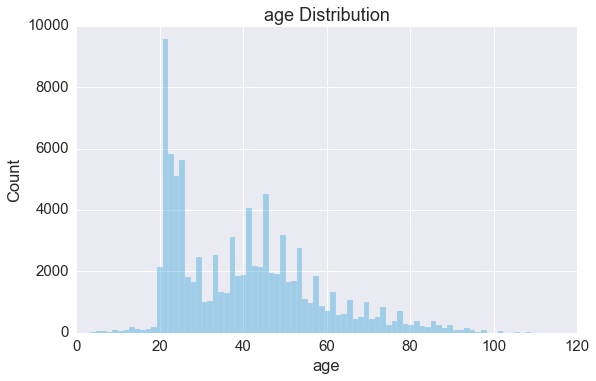

In [24]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style('darkgrid')
    sns.distplot(train_df["age"], bins=80, kde=False)
    sns.plt.title("age Distribution")
    plt.ylabel("Count")

In [25]:
train_df.age[train_df.age==-2].count()

0

In addition to NA, there are people with very small and very high ages. It's also interesting that the distribution is bimodal.   
There are a large number of university aged students, and then another peak around middle-age.  
Let's separate the distribution and move the outliers to the mean of the closest one.

In [26]:
train_df.ix[(train_df.age > -2)&(train_df.age < 18),"age"]  = train_df.ix[(train_df.age >= 18) & (train_df.age <= 30),"age"].mean()
train_df.ix[train_df.age > 100,"age"] = train_df.ix[(train_df.age >= 30) & (train_df.age <= 100),"age"].mean()
train_df.ix[train_df["age"]==-2,"age"] = train_df["age"].mean()
train_df["age"] = train_df["age"].astype(int)

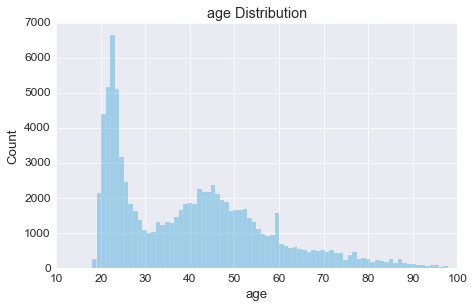

In [27]:
with sns.plotting_context("paper",font_scale=1.5):
    sns.set_style('darkgrid')
    sns.distplot(train_df["age"], bins=80, kde=False)
    sns.plt.title("age Distribution")
    plt.ylabel("Count")

### cod_prov
Province code (customer's address)

In [28]:
train_df.cod_prov.isin([-1]).sum()

448

In [29]:
train_df.ix[train_df.cod_prov.isin([-1]),"cod_prov"] = train_df.cod_prov.median()

### renta
: gross income

In [30]:
train_df.renta[train_df.renta==-1].count()

16495

Here is a feature that is missing a lot of values. Filling missing values with a median might not be accurate.  
let's take a look at the median income by region and age

In [31]:
incomes = train_df.ix[train_df.renta!=-1,:].groupby("cod_prov").agg({"renta":{"MedianIncome":np.median}})
incomes.sort_values(by=("renta","MedianIncome"),inplace=True)
incomes.reset_index(inplace=True)
incomes.cod_prov = incomes.cod_prov.astype("category", categories=[i for i in train_df.cod_prov.unique()],ordered=False)
incomes.head()

,cod_prov,renta
,,MedianIncome
0,27.0,58636.828125
1,49.0,59061.781250
2,25.0,61603.980469
3,45.0,62196.300781
4,21.0,63831.601562


(40000, 180000)

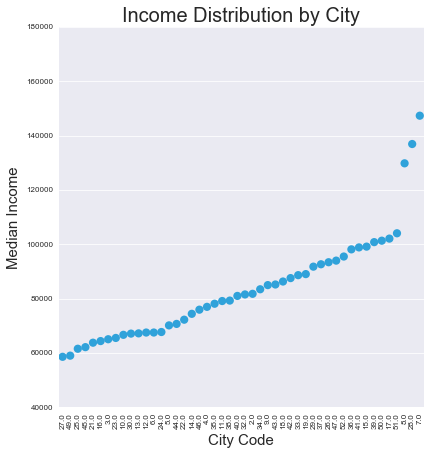

In [32]:
with sns.plotting_context("paper"):
    sns.set_style("darkgrid")
    sns.factorplot(x="cod_prov", y=("renta","MedianIncome"), data=incomes, size=6, linestyles="None", order=(i for i in incomes.cod_prov))

plt.title("Income Distribution by City",size=20)

plt.xticks(rotation=90)
plt.xlabel("City Code",size=15)

plt.ylabel("Median Income",size=15)
plt.ylim(40000,180000)

There's a lot of variation, so I think assigning missing incomes by providence is a good idea. First group the data by city, and reduce to get the median. This intermediate data frame is joined by the original city names to expand the aggregated median incomes, ordered so that there is a 1-to-1 mapping between the rows, and finally the missing values are replaced.

In [33]:
grouped = train_df.groupby("cod_prov").agg({"renta":lambda x: x.median()}).reset_index()
new_incomes = pd.merge(train_df,grouped,how="inner",on="cod_prov").ix[:, ["cod_prov","renta_y"]]
new_incomes = new_incomes.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("cod_prov")
train_df.sort_values("cod_prov",inplace=True)
train_df = train_df.reset_index()
new_incomes = new_incomes.reset_index()

In [36]:
train_df.ix[train_df.renta.isin([-1]),"renta"] = new_incomes.ix[train_df.renta.isin([-1]),"renta"].reset_index()
train_df.ix[train_df.renta.isin([-1]),"renta"] = train_df.ix[train_df.renta.isin([not -1]),"renta"].median()

### left features
There are many categorical features left to be cleaned. First, let's take a look at them.

In [37]:
train_df.isin([-1]).any()

index                    False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                     False
age                      False
ind_nuevo                False
antiguedad               False
indrel                   False
indrel_1mes               True
tiprel_1mes               True
indresi                  False
indext                   False
conyuemp                  True
canal_entrada            False
indfall                  False
cod_prov                 False
ind_actividad_cliente    False
renta                    False
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco_fin_ult1        False
ind_deme_fin_ult1        False
ind_dela_fin_ult1        False
ind_ecue

In [44]:
missing_features = ["indrel_1mes", "tiprel_1mes", "conyuemp", "segmento", "ind_nomina_ult1", "ind_nom_pens_ult1"]
for col in missing_features:
    print("Unique values for {0}:\n{1}\n".format(col,train_df[col].unique()))

Unique values for indrel_1mes:
[ 1 -1  3  2 -2  4]

Unique values for tiprel_1mes:
[ 0  1 -1  2  4]

Unique values for conyuemp:
[-1  0]

Unique values for segmento:
[ 2  1  3 -1]

Unique values for ind_nomina_ult1:
[ 0  1 -1]

Unique values for ind_nom_pens_ult1:
[ 0  1 -1]



conyuemp has one type of values to drop it.

In [45]:
train_df.drop(["conyuemp"], axis=1, inplace=True)

### indrel_1mes

In [46]:
train_df["indrel_1mes"].value_counts()

 1    91582
-1      970
 3       13
 2        4
-2        3
 4        1
Name: indrel_1mes, dtype: int64

filling missing values with the most frequent value, which is 1.

In [125]:
train_df.ix[train_df.indrel_1mes.isin([-1]), "indrel_1mes"] = 1

### tiprel_1mes
Customer relation type at the beginning of the month, 0 (active), 1 (inactive), 2 (former customer), 4 (Potential)

In [126]:
train_df["tiprel_1mes"].value_counts()

 1    46995
 0    44986
-1      989
 2       17
 4        5
Name: tiprel_1mes, dtype: int64

In [128]:
train_df.ix[train_df.tiprel_1mes.isin([-1]), "tiprel_1mes"] = 0

### segmento
segmentation: 01 - VIP, 02 - Individuals 03 - college graduated

In [129]:
train_df["segmento"].value_counts()

 2    54719
 3    32862
 1     4257
-1     1154
Name: segmento, dtype: int64

In [134]:
train_df.ix[train_df.segmento.isin([-1]), "segmento"] = 2

### ind_nomina_ult1, ind_nom_pens_ult1

In [138]:
train_df["ind_nomina_ult1"].value_counts()

 0    87139
 1     5850
-1        3
Name: ind_nomina_ult1, dtype: int64

In [139]:
train_df["ind_nom_pens_ult1"].value_counts()

 0    86627
 1     6362
-1        3
Name: ind_nom_pens_ult1, dtype: int64

The numer of missing values is very small. just replace them with the most common value.

In [146]:
train_df.loc[train_df.ind_nomina_ult1.isin([-1]), "ind_nomina_ult1"] = 0
train_df.loc[train_df.ind_nom_pens_ult1.isin([-1]), "ind_nom_pens_ult1"] = 0

In [154]:
train_df.isin([-1]).any().sum()

0